Domain: x ∈ [0, 1.0]
Grid points: 400
Gamma: 1.4
Initial conditions:
  u(x,0) = sin(πx)
  ρ(x,0) = 1.0
  p(x,0) = ρ^γ = 1.0
Saving at t = 0.25
Time step 500, t = 0.30004
Saving at t = 0.50
Time step 1000, t = 0.59061
Saving at t = 0.75
Time step 1500, t = 0.86479
Saving at t = 1.00
NaN detected in solution. Simulation unstable.


<ipython-input-3-63d752e2af19>:105: RuntimeWarning: invalid value encountered in sqrt
  c = np.sqrt(gamma * p / rho)  # Speed of sound
<ipython-input-3-63d752e2af19>:141: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


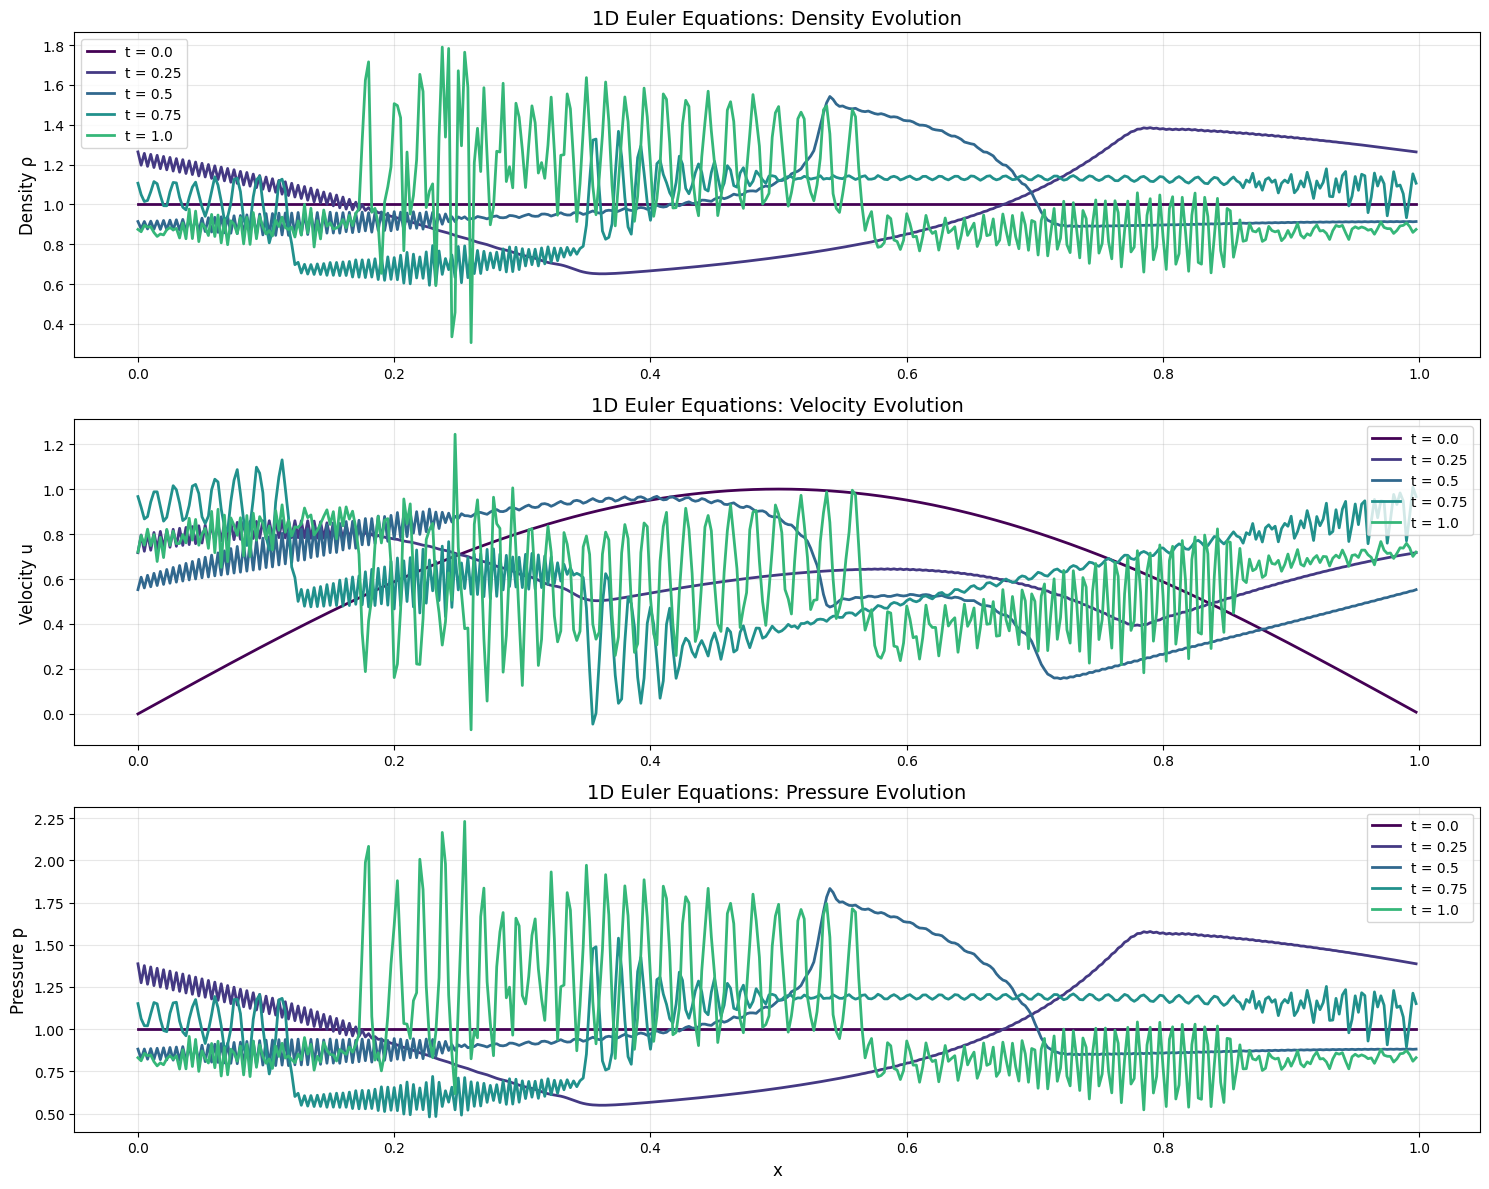

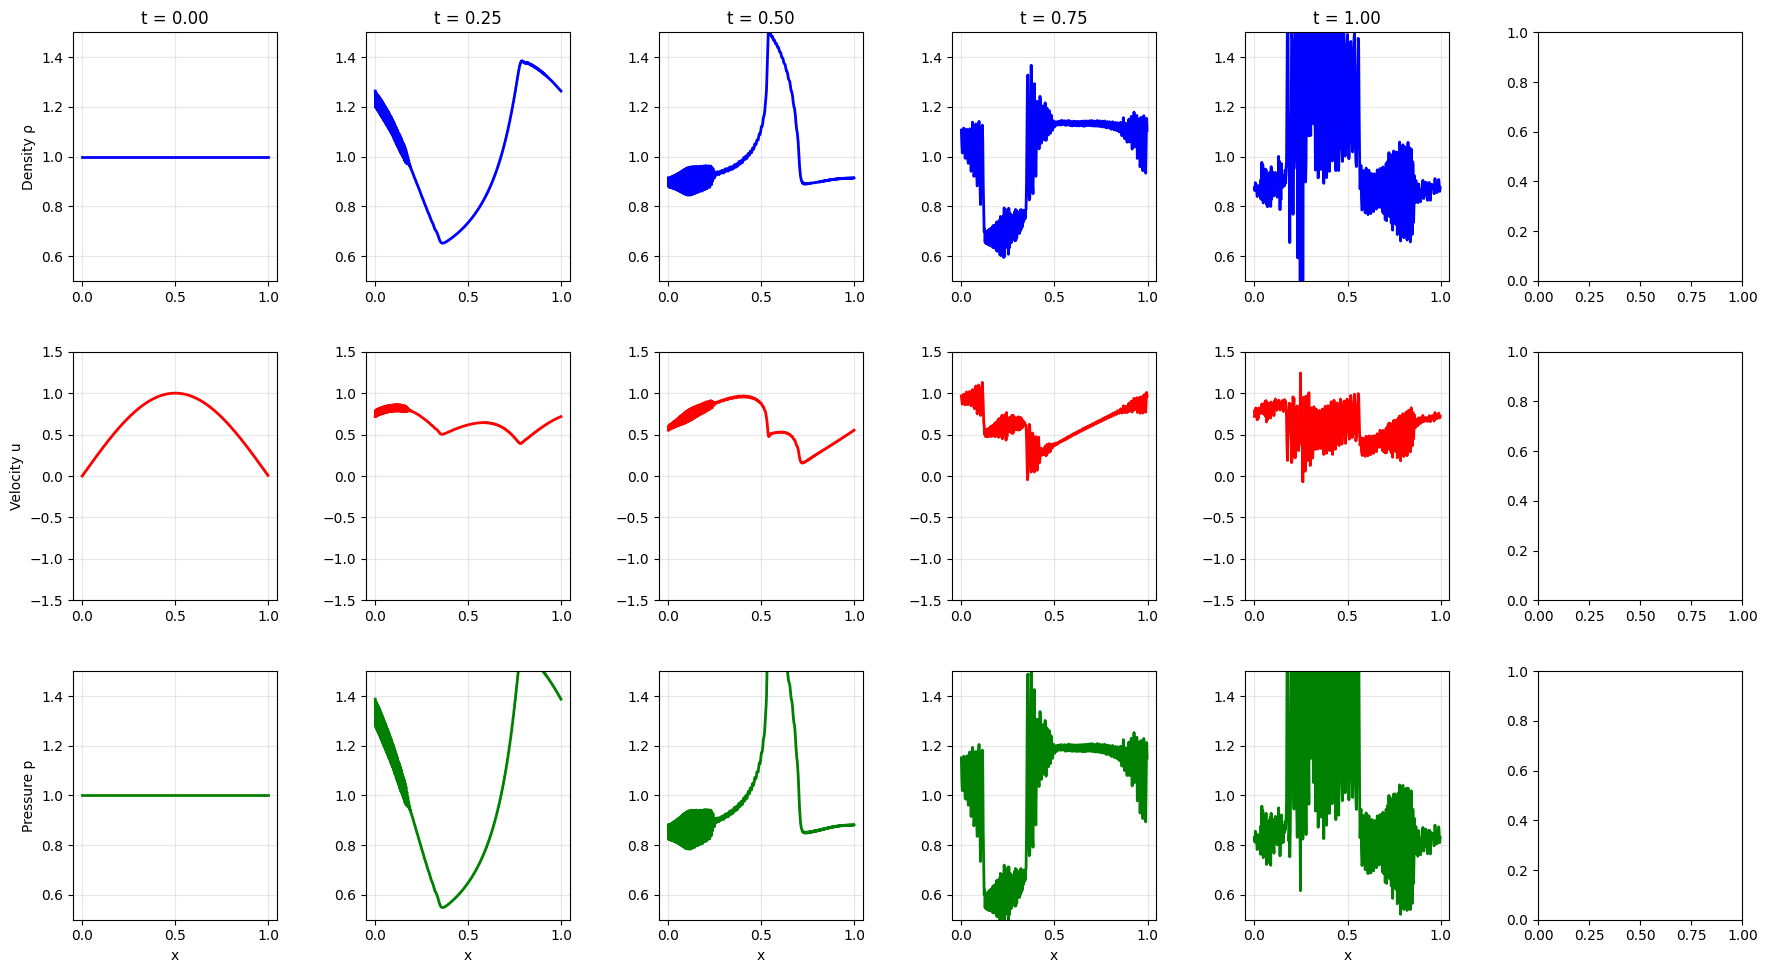

Simulation and visualization complete!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.cm import get_cmap

# Parameters
nx = 400       # More grid points for better resolution
L = 1.0        # Domain length [0,L] is now [0,1]
gamma = 1.4    # Ratio of specific heats for ideal gas
cfl = 0.5      # Lower CFL number for better stability
tmax = 1.25    # Maximum simulation time
nt_max = 5000  # Maximum number of time steps

# Initialize grid
dx = L / nx
x = np.linspace(0, L, nx+1)[:-1]  # Grid points [0,L) for periodic BC

# Initial conditions as specified
u = np.sin(np.pi * x)       # velocity
rho = np.ones_like(x)       # density = 1.0
p = rho**gamma              # pressure = ρ^γ

# Print initial conditions parameters
print(f"Domain: x ∈ [0, {L}]")
print(f"Grid points: {nx}")
print(f"Gamma: {gamma}")
print(f"Initial conditions:")
print(f"  u(x,0) = sin(πx)")
print(f"  ρ(x,0) = 1.0")
print(f"  p(x,0) = ρ^γ = {rho[0]**gamma}")

# Compute initial conserved variables
E = p / ((gamma - 1) * rho) + 0.5 * u**2  # Specific total energy
Q = np.zeros((3, nx))  # Conserved variables [rho, rho*u, rho*E]
Q[0, :] = rho
Q[1, :] = rho * u
Q[2, :] = rho * E

# Store results at different time steps
time_points = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25]  # Requested time points
results = {0.0: {"rho": rho.copy(), "u": u.copy(), "p": p.copy()}}
next_save_idx = 1

# Function to compute fluxes (using a more stable flux formulation)
def compute_flux(Q):
    rho = Q[0, :]
    u = Q[1, :] / rho
    E = Q[2, :] / rho
    p = (gamma - 1) * rho * (E - 0.5 * u**2)

    F = np.zeros_like(Q)
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + p
    F[2, :] = u * (rho * E + p)

    return F

# Implement a 2nd-order Runge-Kutta scheme (higher order for better accuracy)
def rk2_step(Q, dt):
    # First stage
    F = compute_flux(Q)
    Q_star = np.zeros_like(Q)

    # Interior points
    for i in range(1, nx-1):
        flux_diff = (F[:, i+1] - F[:, i-1]) / (2*dx)
        Q_star[:, i] = Q[:, i] - dt * flux_diff

    # Periodic boundary conditions
    flux_diff_left = (F[:, 1] - F[:, nx-1]) / (2*dx)
    flux_diff_right = (F[:, 0] - F[:, nx-2]) / (2*dx)
    Q_star[:, 0] = Q[:, 0] - dt * flux_diff_left
    Q_star[:, nx-1] = Q[:, nx-1] - dt * flux_diff_right

    # Second stage
    F_star = compute_flux(Q_star)
    Q_new = np.zeros_like(Q)

    # Interior points
    for i in range(1, nx-1):
        flux_diff = (F_star[:, i+1] - F_star[:, i-1]) / (2*dx)
        Q_new[:, i] = 0.5 * (Q[:, i] + Q_star[:, i] - dt * flux_diff)

    # Periodic boundary conditions
    flux_diff_left = (F_star[:, 1] - F_star[:, nx-1]) / (2*dx)
    flux_diff_right = (F_star[:, 0] - F_star[:, nx-2]) / (2*dx)
    Q_new[:, 0] = 0.5 * (Q[:, 0] + Q_star[:, 0] - dt * flux_diff_left)
    Q_new[:, nx-1] = 0.5 * (Q[:, nx-1] + Q_star[:, nx-1] - dt * flux_diff_right)

    # Enforce periodic boundary conditions explicitly
    Q_new[:, 0] = Q_new[:, nx-1]

    return Q_new

# Time stepping
t = 0
nt = 0

while t < tmax and nt < nt_max:
    # Compute time step based on CFL condition
    rho = Q[0, :]
    u = Q[1, :] / rho
    E = Q[2, :] / rho
    p = (gamma - 1) * rho * (E - 0.5 * u**2)
    c = np.sqrt(gamma * p / rho)  # Speed of sound
    dt = cfl * dx / np.max(np.abs(u) + c)

    # Make sure we don't overshoot the next time point
    if next_save_idx < len(time_points):
        dt = min(dt, time_points[next_save_idx] - t)

    # Update solution
    Q = rk2_step(Q, dt)

    # Update time
    t += dt
    nt += 1

    # Extract primitive variables
    rho = Q[0, :]
    u = Q[1, :] / rho
    E = Q[2, :] / rho
    p = (gamma - 1) * rho * (E - 0.5 * u**2)

    # Save results at specified time points
    if next_save_idx < len(time_points) and abs(t - time_points[next_save_idx]) < 1e-10:
        print(f"Saving at t = {time_points[next_save_idx]:.2f}")
        results[time_points[next_save_idx]] = {"rho": rho.copy(), "u": u.copy(), "p": p.copy()}
        next_save_idx += 1

    # Print progress
    if nt % 500 == 0:
        print(f"Time step {nt}, t = {t:.5f}")

    # Check for NaN values (indicates instability)
    if np.isnan(Q).any():
        print("NaN detected in solution. Simulation unstable.")
        break

# Create plots with all time steps in the same plot for each variable
cmap = get_cmap('viridis')
colors = [cmap(i/len(time_points)) for i in range(len(time_points))]

plt.figure(figsize=(15, 12))

# Plot density
plt.subplot(3, 1, 1)
for i, time in enumerate(time_points):
    if time in results:
        plt.plot(x, results[time]["rho"], label=f"t = {time}", color=colors[i], linewidth=2)
plt.ylabel("Density ρ", fontsize=12)
plt.title("1D Euler Equations: Density Evolution", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Plot velocity
plt.subplot(3, 1, 2)
for i, time in enumerate(time_points):
    if time in results:
        plt.plot(x, results[time]["u"], label=f"t = {time}", color=colors[i], linewidth=2)
plt.ylabel("Velocity u", fontsize=12)
plt.title("1D Euler Equations: Velocity Evolution", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Plot pressure
plt.subplot(3, 1, 3)
for i, time in enumerate(time_points):
    if time in results:
        plt.plot(x, results[time]["p"], label=f"t = {time}", color=colors[i], linewidth=2)
plt.ylabel("Pressure p", fontsize=12)
plt.xlabel("x", fontsize=12)
plt.title("1D Euler Equations: Pressure Evolution", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig("euler_1d_solution_all_timesteps.png", dpi=300, bbox_inches="tight")
plt.show()

# Also create individual plots for clearer visualization
fig, axs = plt.subplots(3, len(time_points), figsize=(18, 10))
fig.tight_layout(pad=3.0)

for i, time in enumerate(sorted(results.keys())):
    data = results[time]

    axs[0, i].plot(x, data["rho"], 'b-', linewidth=2)
    axs[0, i].set_title(f"t = {time:.2f}")
    axs[0, i].set_ylim(0.5, 1.5)
    axs[0, i].grid(True, alpha=0.3)

    axs[1, i].plot(x, data["u"], 'r-', linewidth=2)
    axs[1, i].set_ylim(-1.5, 1.5)
    axs[1, i].grid(True, alpha=0.3)

    axs[2, i].plot(x, data["p"], 'g-', linewidth=2)
    axs[2, i].set_ylim(0.5, 1.5)
    axs[2, i].grid(True, alpha=0.3)

    if i == 0:
        axs[0, i].set_ylabel("Density ρ")
        axs[1, i].set_ylabel("Velocity u")
        axs[2, i].set_ylabel("Pressure p")

    axs[2, i].set_xlabel("x")

plt.savefig("euler_1d_solution_grid.png", dpi=300, bbox_inches="tight")
plt.show()

print("Simulation and visualization complete!")

Time step 100, t = 0.431
Time step 200, t = 0.835
Time step 300, t = 1.282
Time step 400, t = 1.723


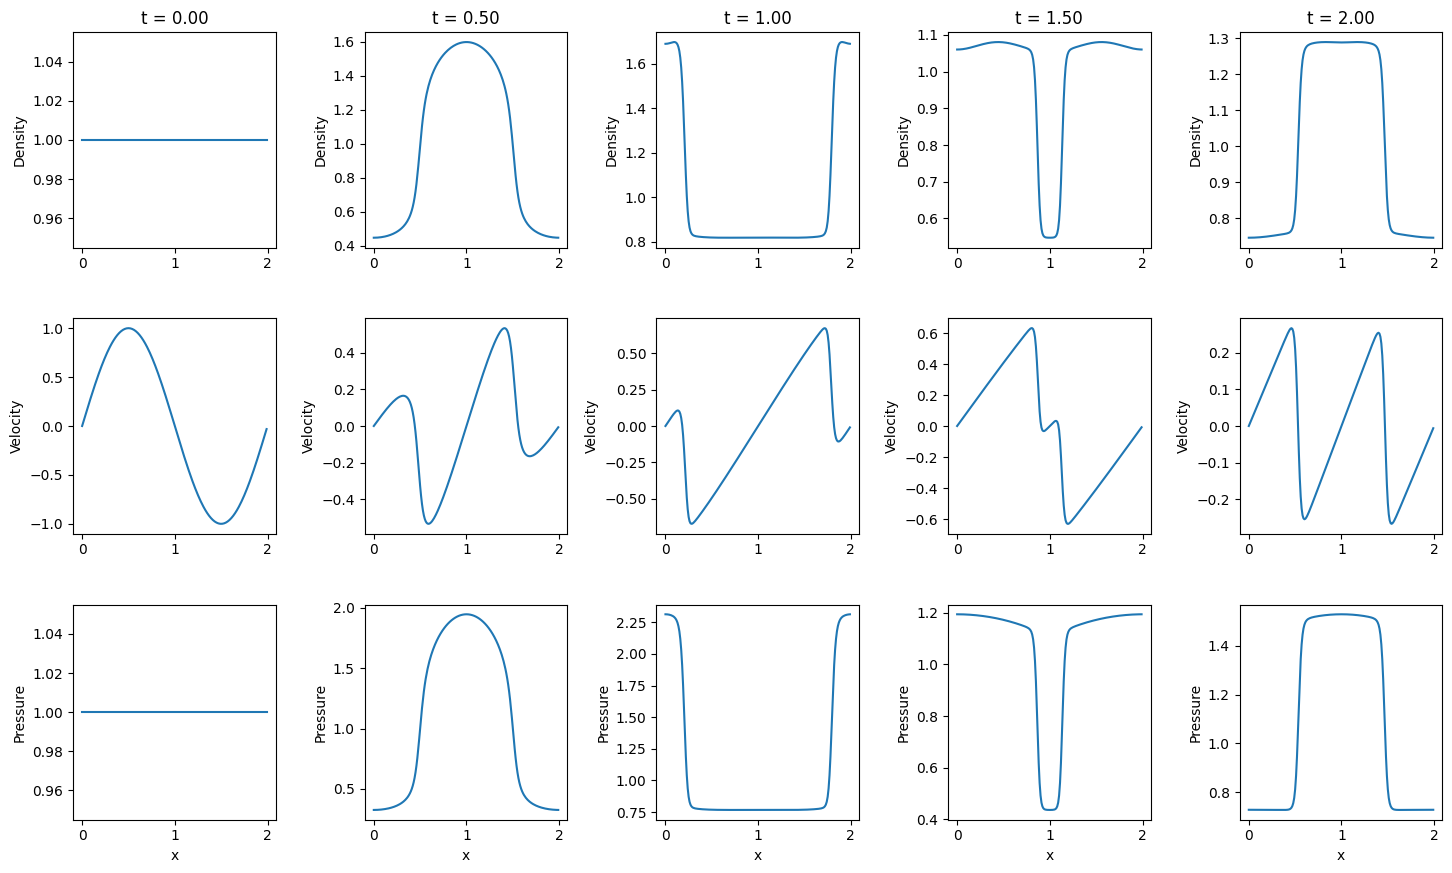

ValueError: Format 'gif' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

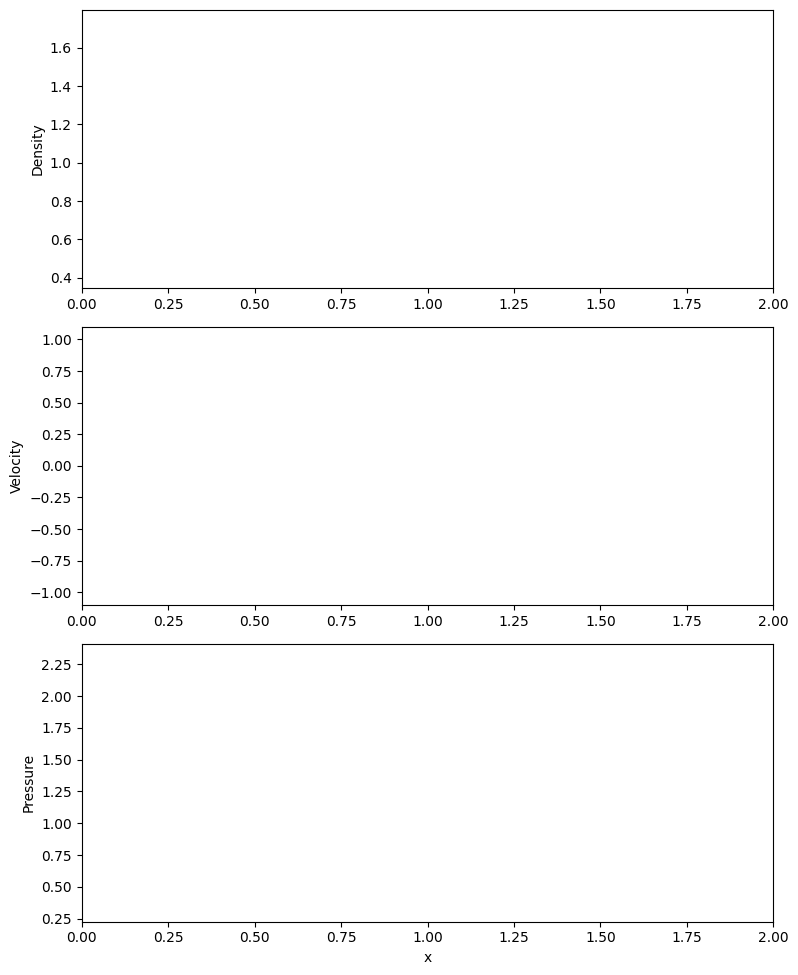

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Parameters
nx = 200  # Number of grid points
L = 2.0   # Domain length [0,L]
gamma = 1.4  # Ratio of specific heats for ideal gas
cfl = 0.8  # CFL number for stability
tmax = 2.0  # Maximum simulation time
nt_max = 1000  # Maximum number of time steps

# Initialize grid
dx = L / nx
x = np.linspace(0, L - dx, nx)  # Grid points (excluding last point for periodic BC)

# Initial conditions
rho0 = 1.0  # Base density
p0 = 1.0    # Base pressure
u = np.sin(np.pi * x)  # Initial velocity as specified
rho = rho0 * np.ones_like(x)  # Uniform initial density
p = p0 * np.ones_like(x)      # Uniform initial pressure

# Compute initial conserved variables
E = p / ((gamma - 1) * rho) + 0.5 * u**2  # Specific total energy
Q = np.zeros((3, nx))  # Conserved variables [rho, rho*u, rho*E]
Q[0, :] = rho
Q[1, :] = rho * u
Q[2, :] = rho * E

# Store results at different time steps
time_points = np.linspace(0, tmax, 5)  # Save 5 time points
results = {0.0: {"rho": rho.copy(), "u": u.copy(), "p": p.copy()}}
next_save_idx = 1

# Function to compute fluxes
def compute_flux(Q):
    rho = Q[0, :]
    u = Q[1, :] / rho
    E = Q[2, :] / rho
    p = (gamma - 1) * rho * (E - 0.5 * u**2)

    F = np.zeros_like(Q)
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + p
    F[2, :] = u * (rho * E + p)

    return F

# Lax-Friedrichs scheme
def lax_friedrichs_step(Q, dt):
    F = compute_flux(Q)

    Q_new = np.zeros_like(Q)

    for i in range(1, nx-1):
        Q_new[:, i] = 0.5 * (Q[:, i+1] + Q[:, i-1]) - 0.5 * dt/dx * (F[:, i+1] - F[:, i-1])

    # Periodic boundary conditions
    Q_new[:, 0] = 0.5 * (Q[:, 1] + Q[:, nx-1]) - 0.5 * dt/dx * (F[:, 1] - F[:, nx-1])
    Q_new[:, nx-1] = 0.5 * (Q[:, 0] + Q[:, nx-2]) - 0.5 * dt/dx * (F[:, 0] - F[:, nx-2])

    return Q_new

# Time stepping
t = 0
nt = 0

while t < tmax and nt < nt_max:
    # Compute time step based on CFL condition
    rho = Q[0, :]
    u = Q[1, :] / rho
    E = Q[2, :] / rho
    p = (gamma - 1) * rho * (E - 0.5 * u**2)
    c = np.sqrt(gamma * p / rho)  # Speed of sound
    dt = cfl * dx / np.max(np.abs(u) + c)

    # Make sure we don't overshoot tmax
    if t + dt > tmax:
        dt = tmax - t

    # Update solution
    Q = lax_friedrichs_step(Q, dt)

    # Update time
    t += dt
    nt += 1

    # Extract primitive variables
    rho = Q[0, :]
    u = Q[1, :] / rho
    E = Q[2, :] / rho
    p = (gamma - 1) * rho * (E - 0.5 * u**2)

    # Save results at specified time points
    if next_save_idx < len(time_points) and t >= time_points[next_save_idx]:
        results[time_points[next_save_idx]] = {"rho": rho.copy(), "u": u.copy(), "p": p.copy()}
        next_save_idx += 1

    # Print progress
    if nt % 100 == 0:
        print(f"Time step {nt}, t = {t:.3f}")

# Plot results
fig, axs = plt.subplots(3, len(results), figsize=(15, 9))
fig.tight_layout(pad=3.0)

for i, (time, data) in enumerate(sorted(results.items())):
    axs[0, i].plot(x, data["rho"])
    axs[0, i].set_title(f"t = {time:.2f}")
    axs[0, i].set_ylabel("Density")

    axs[1, i].plot(x, data["u"])
    axs[1, i].set_ylabel("Velocity")

    axs[2, i].plot(x, data["p"])
    axs[2, i].set_ylabel("Pressure")

    if i == 0:
        for j in range(3):
            axs[j, i].set_ylabel(["Density", "Velocity", "Pressure"][j])

    axs[2, i].set_xlabel("x")

plt.savefig("euler_1d_solution.png", dpi=300, bbox_inches="tight")
plt.show()

# Create animation
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
lines = []
for i in range(3):
    line, = axs[i].plot([], [])
    lines.append(line)
    axs[i].set_xlim(0, L)

axs[0].set_ylabel("Density")
axs[1].set_ylabel("Velocity")
axs[2].set_ylabel("Pressure")
axs[2].set_xlabel("x")

# Set y limits based on all data
rho_min = min(min(data["rho"]) for data in results.values())
rho_max = max(max(data["rho"]) for data in results.values())
u_min = min(min(data["u"]) for data in results.values())
u_max = max(max(data["u"]) for data in results.values())
p_min = min(min(data["p"]) for data in results.values())
p_max = max(max(data["p"]) for data in results.values())

axs[0].set_ylim(rho_min - 0.1, rho_max + 0.1)
axs[1].set_ylim(u_min - 0.1, u_max + 0.1)
axs[2].set_ylim(p_min - 0.1, p_max + 0.1)

time_text = fig.suptitle("")

def init():
    for line in lines:
        line.set_data([], [])
    time_text.set_text("")
    return lines + [time_text]

def animate(i):
    time = list(sorted(results.keys()))[i]
    lines[0].set_data(x, results[time]["rho"])
    lines[1].set_data(x, results[time]["u"])
    lines[2].set_data(x, results[time]["p"])
    time_text.set_text(f"Time = {time:.2f}")
    return lines + [time_text]

ani = animation.FuncAnimation(fig, animate, frames=len(results),
                             init_func=init, blit=True, interval=500)

plt.tight_layout()
plt.savefig("euler_1d_animation.gif", writer="pillow")
plt.show()

print("Simulation and visualization complete!")